## 作业五——自然语言处理
本次作业的目的是让同学们体验自然语言处理的过程，训练一个将法语翻译成英语的RNN模型。

本次作业需要完成的内容：
- 仔细阅读代码，补全TODO标记的内容，实现翻译器
- 试着调整学习率、`batch_size`、`hidden_size`等超参数，观察它们对实验结果的影响。

需要提交的内容：
- 补全后的代码 (.py 或 .ipynb 文件)。只需要提交初始版本。
- 实验报告（一个PDF文件），要求记录:
    - 例句的翻译结果（至少一句，英语和法语都写入报告中）与最终准确率。
    - 调整上述超参数得到的实验结果（包括损失函数曲线等），并作简要分析。

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import unicodedata
import re
import random
import time
import math

import jittor as jt
import jittor.optim as optim
import jittor.nn as nn
from jittor.dataset import Dataset
from tqdm import tqdm
from typing import Tuple, Optional
from queue import PriorityQueue
jt.flags.use_cuda=True

# The max length of sequence
MAX_LENGTH = 10

# Start of Sequence token
SOS_token = 0

# End of Sequence token
EOS_token = 1

# Unkown word token
UNK_token = 2

batch_size = 64

[i 1217 08:05:47.847770 64 lock.py:85] Create lock file:/root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x00/AMDEPYC740224-xf1/176f/jittor.lock
[i 1217 08:05:47.880755 64 compiler.py:956] Jittor(1.3.10.0) src: /root/miniconda3/envs/ai_course/lib/python3.8/site-packages/jittor
[i 1217 08:05:47.894729 64 compiler.py:957] g++ at /usr/bin/g++(12.4.0)
[i 1217 08:05:47.894888 64 compiler.py:958] cache_path: /root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x00/AMDEPYC740224-xf1/176f/default
[i 1217 08:05:47.932980 64 install_cuda.py:96] cuda_driver_version: [12, 4]
[i 1217 08:05:47.933983 64 install_cuda.py:82] needed restart but not /root/miniconda3/envs/ai_course/bin/python ['-m', 'ipykernel_launcher', '--f=/root/.local/share/jupyter/runtime/kernel-v31cf371cf648a0e0f823aa62fd16e4866d0540853.json'], you can ignore this warning.
[i 1217 08:05:47.973033 64 __init__.py:412] Found /root/.cache/jittor/jtcuda/cuda12.2_cudnn8_linux/bin/nvcc(12.2.140) at /root/.cache/jittor

[i 1217 08:05:57.071027 32 log.cc:351] Load log_sync: 1
[i 1217 08:06:14.918347 32 __init__.py:227] Total mem: 503.57GB, using 16 procs for compiling.


[i 1217 08:06:55.882061 32 log.cc:351] Load log_sync: 1
[i 1217 08:06:55.883867 32 jit_compiler.cc:28] Load cc_path: /usr/bin/g++


Compiling jittor_core(151/151) used: 39.722s eta: 0.000s


[i 1217 08:06:56.097170 32 init.cc:63] Found cuda archs: [89,]
[i 1217 08:06:56.140749 32 compile_extern.py:388] Downloading cutt...
[i 1217 08:06:56.188191 32 compile_extern.py:401] installing cutt...


[i 1217 08:07:08.775048 32 compiler.py:34] Create cache dir: /root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x00/AMDEPYC740224-xf1/176f/default/cu12.2.140_sm_89/custom_ops


Compiling libcutt(9/9) used: 12.472s eta: 0.000s


[i 1217 08:07:15.542422 32 compiler.py:34] Create cache dir: /root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x00/AMDEPYC740224-xf1/176f/default/cu12.2.140_sm_89/cuda


Compiling gen_ops_mkl_conv_backward_x_mkl_conv_backward_w_mk___hashbc87cd(7/7) used: 4.410s eta: 0.000s
Compiling gen_ops_cub_where_cub_test_cub_cumsum_cub_arg_redu___hash7af395(6/6) used: 2.596s eta: 0.000s
Compiling gen_ops_cublas_test_cublas_matmul_cublas_acc_matmu___hash10a707(8/8) used: 2.259s eta: 0.000s
Compiling gen_ops_cudnn_rnn_cudnn_conv3d_cudnn_rnn_backward____hash4a5ca9(16/16) used: 6.359s eta: 0.000s


[i 1217 08:07:35.972994 32 cuda_flags.cc:55] CUDA enabled.


Compiling gen_ops_cusparse_spmmcoo_cusparse_spmmcsr(5/5) used: 2.198s eta: 0.000s


### 自然语言数据的预处理
本次实验中，我们仅使用基本的拉丁字母，并将所有句子进行分词处理。

我们将语料库中的所有词组成一个词典，每个单词对应一个整数序号。我们通过这种方式将一个句子转变为了一个整数序列。


In [2]:
# Download the dataset, save to eng-fra.txt
import os
os.system("wget -O eng-fra.txt 'https://cloud.tsinghua.edu.cn/f/d4578477500747d39855/?dl=1'")

--2025-12-17 08:07:35--  https://cloud.tsinghua.edu.cn/f/d4578477500747d39855/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.15.69, 2402:f000:1:402:101:6:15:69
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.15.69|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/dbb435d4-5c12-442b-927d-a8cf1a5ff309/eng-fra.txt [following]
--2025-12-17 08:07:36--  https://cloud.tsinghua.edu.cn/seafhttp/files/dbb435d4-5c12-442b-927d-a8cf1a5ff309/eng-fra.txt
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 9541158 (9.1M) [text/plain]
Saving to: ‘eng-fra.txt’

     0K .......... .......... .......... .......... ..........  0%  511K 18s
    50K .......... .......... .......... .......... ..........  1% 2.05M 11s
   100K .......... .......... .......... .......... ..........  1% 2.04M 9s
   150K .......... .......... .......... ..

0

In [3]:
# Language Helpers
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Word Dictionary
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>", 2: "<UNK>"}
        self.n_words = 3  # Count SOS and EOS
        self.min_freq = 3

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = UNK_token
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1
        if self.word2count[word] == self.min_freq:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

    def get_index(self, word):
        return self.word2index.get(word, UNK_token)



In [4]:
# Read data
def filterPair(p:Tuple[str, str]):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH \
        # and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def readLangs(data_file, lang1_name, lang2_name, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    with open(data_file, mode='r', encoding='utf-8') as f:
        lines = f.readlines()

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2_name)
        output_lang = Lang(lang1_name)
    else:
        input_lang = Lang(lang1_name)
        output_lang = Lang(lang1_name)

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = readLangs('eng-fra.txt', 'eng', 'fra', reverse=True)
print("Read %s sentence pairs" % len(pairs))
pairs = filterPairs(pairs)
print("Trimmed to %s sentence pairs" % len(pairs))
print("Counting words...")
for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
print("Counted words:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)


Reading lines...
Read 135842 sentence pairs
Trimmed to 95170 sentence pairs
Counting words...
Counted words:
fra 7874
eng 5506


### 数据集搭建
完成预处理后，我们得到了一组序列对，所有序列的长度均不超过`MAX_LENGTH`。

这些序列的长度是互不一致的，这使得我们在后续进行计算时会遇到困难。为此，我们需要在这些序列后面补0，使得序列长度一致，并记录下正确的序列长度。

In [5]:
# Build Dataset
class TranslateDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang, max_length=MAX_LENGTH, **kwargs):
        super().__init__(**kwargs)
        self._pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.max_length = max_length
        self.total_len = len(self._pairs)

    def sentence_to_indexes_with_EOS(self, lang:Lang, sentence:str):
        """Convert the string sentence into a number sequence.
        Words in the sentence are separated by spaces.

        Args:
            lang (Lang): The dictionary.
            sentence (str): The sentence to be coverted.

        Returns:
            jt.Var: the converted sequence.
        """
        # TODO(1): Split the sentence into multiple words \
        # and then convert them into integer sequences `indexes`

        # Your code starts here
        words = sentence.split(' ')
        indexes = [lang.get_index(word) for word in words]
        # Your code ends here

        indexes.append(EOS_token)
        return jt.array(indexes, dtype=jt.int32)

    def pad_sentence(self, sentence:jt.Var):
        sentence_len = sentence.shape[0]
        var = jt.zeros((self.max_length, ), dtype=jt.int32)
        weight = jt.zeros((self.max_length), dtype=jt.float32)
        length = jt.empty((1, ), dtype=jt.int32)
        var[:sentence_len] = sentence
        weight[:sentence_len] = 1
        length[0] = sentence_len
        return var, weight, length

    def __getitem__(self, index):
        input_str, target_str = self._pairs[index]
        input_var = self.sentence_to_indexes_with_EOS(self.input_lang, input_str)
        target_var = self.sentence_to_indexes_with_EOS(self.output_lang, target_str)
        input, input_weight, input_length = self.pad_sentence(input_var)
        target, target_weight, target_length = self.pad_sentence(target_var)
        return [
            input, target, input_weight, target_weight, input_length, target_length
        ], (input_str, target_str)

    def process_sentence(self, sentence):
        input_var = self.sentence_to_indexes_with_EOS(self.input_lang, normalizeString(sentence))
        input, input_weight, input_length = self.pad_sentence(input_var)
        return input.unsqueeze(0), input_weight.unsqueeze(0), input_length.unsqueeze(0)

random.seed(223514)
random.shuffle(pairs)
n_train = int(len(pairs) * 0.9)
train_pairs = pairs[:n_train]
test_pairs = pairs[n_train:]
train_dataset = TranslateDataset(train_pairs, input_lang, output_lang, batch_size=batch_size, shuffle=True, endless=True)
test_dataset = TranslateDataset(test_pairs, input_lang, output_lang, batch_size=1, shuffle=False)
for data in train_dataset:
    print(data[0][0].shape)
    break

for data in test_dataset:
    print(data[0][0].shape)
    break


[64,10,]
[1,10,]


### Encoder和Decoder
`EncoderRNN`和`AttnDecoderRNN`分别为编码器和解码器的单个单元。

注：`AttnDecoderRNN`采用了注意力结构，需要利用编码器的所有隐藏层输出进行计算。

In [6]:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def execute(self, input, hidden):
        """EncoderRNN

        Args:
            input (jt.Var): Input tensor with shape [1, B]
            hidden (jt.Var): Hidden tensor with shape [1, B, hidden_size]

        Returns:
            Tuple[jt.Var, jt.Var]: output tensor, new hidden tensor
        """
        assert input.shape[0] == 1
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def execute(self, input:jt.Var, hidden:jt.Var, encoder_outputs:jt.Var):
        """AttnDecoderRNN

        Args:
            input (jt.Var): Input tensor with shape [1, B]
            hidden (jt.Var): Hidden tensor with shape [1, B, hidden_size]
            encoder_outputs (jt.Var): Encoder outputs with shape [B, max_length, hidden_size]

        Returns:
            _type_: _description_
        """
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)       # [1, B, hidden_size]

        attn_input = jt.concat([embedded, hidden], dim=-1).squeeze(0)   # [B, hidden_size]
        attn_weights = nn.softmax(self.attn(attn_input), dim=1)                 # [B, max_length]
        attn_applied = jt.bmm(attn_weights.unsqueeze(1), encoder_outputs)       # [B, 1, hidden_size]

        output = jt.concat(
            [embedded.squeeze(0), attn_applied.squeeze(1)],
            dim=1)                                                              # [B, hidden_size * 2]
        output = self.attn_combine(output).unsqueeze(0)                         # [1, B, hidden_size]

        output = nn.relu(output)
        output, hidden = self.gru(output, hidden)

        output = self.out(output.squeeze(0))                                    # [B, output_size]
        output = nn.log_softmax(output, dim=1)
        return output, hidden

dummy_input = jt.array(np.random.randint(0, 15, (1, 5)))
dummy_hidden = jt.randn(1, 5, 20)
dummy_encoder_output = jt.randn(5, 10, 20)
dummy_rnn = EncoderRNN(15, 20)
dummy_output, dummy_o_hidden = dummy_rnn(dummy_input, dummy_hidden)
# [1,5,20,] [1,5,20,]
print(dummy_output.shape, dummy_o_hidden.shape)
dummy_rnn = AttnDecoderRNN(20, 15)
dummy_output, dummy_o_hidden = dummy_rnn(dummy_input, dummy_hidden, dummy_encoder_output)
# [5,15,] [1,5,20,]
print(dummy_output.shape, dummy_o_hidden.shape)


[1,5,20,] [1,5,20,]
[5,15,] [1,5,20,]


### 编码过程
如图，$h_0$为默认初始隐藏层，$x_1, x_2, \cdots, x_N$为输入序列，$C$为RNN最终输出。

需要注意的是，我们每次输入的是一组序列，这些序列的长度可能不一致。我们根据序列的原始长度找出实际的最终输出。

![](imgs/encode.png)


In [7]:
class EncoderDecoder(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, max_length=MAX_LENGTH):
        super(EncoderDecoder, self).__init__()
        self.encoder = EncoderRNN(input_size, hidden_size)
        self.decoder = AttnDecoderRNN(hidden_size, output_size, max_length=max_length)
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size

    def encode(self, input:jt.Var, input_weights:jt.Var, input_lengths:jt.Var):
        """Encode the inputs

        Args:
            input (jt.Var): Input Sequence with shape [B, max_length], int
            input_weights (jt.Var): Input weight (valid to be 1) with shape [B, max_length], float
            input_lengths (jt.Var): Input length with shape [B, 1], int
        """
        B = input.shape[0]
        # Encode
        encoder_outputs = []
        encoder_hiddens = []
        encoder_hidden = jt.zeros([1, B, self.hidden_size])
        for i in range(self.max_length):
            slice_input = jt.unsqueeze(input[:, i], 0)         # [1, B]
            encoder_output, encoder_hidden = self.encoder(slice_input, encoder_hidden)
            encoder_outputs.append(encoder_output)
            encoder_hiddens.append(encoder_hidden)
        encoder_outputs = jt.concat(encoder_outputs, 0)         # [max_length, B, hidden_size]
        encoder_outputs = encoder_outputs.permute((1, 0, 2))    # [B, max_length, hidden_size]
        encoder_outputs = encoder_outputs * input_weights.unsqueeze(-1)
                                                        
        # Find the latest hidden layer of every input sequence
        encoder_hiddens = jt.concat(encoder_hiddens, 0)         # [max_length, B, hidden_size]
        encoder_ends = (input_lengths.squeeze(1) - 1, jt.arange(B))
        encoder_hiddens = encoder_hiddens[encoder_ends]         # [B, hidden_size]
        return encoder_outputs, encoder_hiddens

    def loss(self, input:jt.Var, target:jt.Var,
             input_weights:jt.Var, target_weights:jt.Var,
             input_lengths:jt.Var, target_lengths:jt.Var,
             decode_func:None):
        """Loss

        Args:
            input (jt.Var): Input Sequence with shape [B, max_length], int
            target (jt.Var): Target Sequence with shape [B, max_length], int
            input_weights (jt.Var): Input weight (valid to be 1) with shape [B, max_length], float
            target_weights (jt.Var): Target weight (valid to be 1) with shape [B, max_length], float
            input_lengths (jt.Var): Input length with shape [B, 1], int
            target_lengths (jt.Var): Target length with shape [B, 1], int
        """
        B = input.shape[0]
        e_outputs, e_hiddens = self.encode(input, input_weights, input_lengths)
        decoder_outputs = decode_func(self.decoder, e_outputs, e_hiddens, target)
        assert isinstance(decoder_outputs, jt.Var)
        target = target.reshape(B * self.max_length)
        target_weights = target_weights.reshape(B * self.max_length)
        decoder_outputs = decoder_outputs.reshape(B * self.max_length, self.output_size)
        loss = nn.nll_loss(decoder_outputs, target) * target_weights
        loss = jt.reshape(loss, (B, self.max_length)).sum(dim=-1, keepdims=True)
        return loss.mean()

    def generate(self, input:jt.Var, input_weights:jt.Var, input_lengths:jt.Var, decode_func=None):
        e_outputs, e_hiddens = self.encode(input, input_weights, input_lengths)
        return decode_func(self.decoder, e_outputs, e_hiddens)

    def execute(self, *args, **kwargs):
        if self.is_training():
            return self.loss(*args, **kwargs)
        return self.generate(*args, **kwargs)

dummy_model = EncoderDecoder(30, 40, 50)
dummy_model.train()
dummy_input = jt.randint(0, 30, (5, 10))
dummy_iweight = jt.ones_like(dummy_input).float32()
dummy_ilength = jt.randint(3, 11, (5, 1))
dummy_target = jt.randint(0, 40, (5, 10))
dummy_oweight = jt.ones_like(dummy_target).float32()
dummy_olength = jt.randint(3, 11, (5, 1))

### Teacher Forcing
Teacher Forcing思想：在训练过程中，模型的每一步输入使用真实的目标序列（ground truth），而不是模型自己生成的输出

![](imgs/teacher_forcing.png)

In [8]:
def decode_teacher_forcing(decoder, e_outputs:jt.Var, e_hiddens:jt.Var, target:jt.Var):
    """Decoding Process with teacher forcing

    Args:
        e_outputs (jt.Var): Encoder outputs with shape [B, max_length, hidden_size]
        e_hiddens (jt.Var): Encoder hiddens with shape [B, hidden_size]
        target (jt.Var): Target results with shape [B, max_length], int

    Returns:
        decoder_outputs (jt.Var): Decoder outputs with shape [B, max_length, output_size]
    """
    B, L, _ = e_outputs.shape
    decoder_hidden = e_hiddens.unsqueeze(0)                 # [1, B, hidden_size]
    decoder_input = jt.array([[SOS_token]], dtype=jt.int32)
    decoder_input = jt.repeat(decoder_input, (1, B))        # [1, B]
    decoder_outputs = []
    for i in range(L):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, e_outputs)
        decoder_outputs.append(decoder_output)
        decoder_input = target[:, i].unsqueeze(0)           # [1, B]
    decoder_outputs = jt.stack(decoder_outputs, dim=1)      # [B, max_length, output_size]
    return decoder_outputs

loss = dummy_model(
    dummy_input, dummy_target, dummy_iweight, dummy_oweight, dummy_ilength, dummy_olength,
    decode_func = decode_teacher_forcing)
print(loss.item())


Compiling Operators(8/51) used: 6.31s eta: 33.9s 10/51) used: 7.32s eta:   30s 15/51) used: 9.32s eta: 22.4s 16/51) used: 10.3s eta: 22.6s 19/51) used: 12.4s eta: 20.8s 21/51) used: 13.4s eta: 19.1s 24/51) used: 15.4s eta: 17.3s 25/51) used: 16.4s eta: 17.1s 28/51) used: 18.4s eta: 15.1s 33/51) used: 19.4s eta: 10.6s 34/51) used: 21.4s eta: 10.7s 36/51) used: 22.4s eta: 9.35s 40/51) used: 23.4s eta: 6.44s 44/51) used: 24.4s eta: 3.89s 45/51) used: 25.4s eta: 3.39s 48/51) used: 26.5s eta: 1.65s 50/51) used: 27.5s eta: 0.549s 51/51) used: 28.5s eta:    0s 


37.195762634277344


### Free-running
Free running直接使用上一个时间步的输出作为当前神经元的输入。

![](imgs/free_running.png)

In [ ]:
def decode_free_run(decoder:nn.Module, e_outputs:jt.Var, e_hiddens:jt.Var, target:jt.Var):
    """Decoding Process Free run

    Args:
        e_outputs (jt.Var): Encoder outputs with shape [B, max_length, hidden_size]
        e_hiddens (jt.Var): Encoder hiddens with shape [B, hidden_size]
        target (jt.Var): Target results with shape [B, max_length], int

    Returns:
        decoder_outputs (jt.Var): Decoder outputs with shape [B, max_length, output_size]
    """

    B, L, _ = e_outputs.shape
    decoder_hidden = e_hiddens.unsqueeze(0)                 # [1, B, hidden_size]
    decoder_input = jt.array([[SOS_token]], dtype=jt.int32)
    decoder_input = jt.repeat(decoder_input, (1, B))        # [1, B]
    decoder_outputs = []
    # TODO(2): Free Running for model training

    # Your code starts here
    for i in range(L):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, e_outputs)
        decoder_outputs.append(decoder_output)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.transpose(0, 1)  # [1, B]
    # Your code ends here

    decoder_outputs = jt.stack(decoder_outputs, dim=1)      # [B, max_length, output_size]
    return decoder_outputs
loss = dummy_model(
    dummy_input, dummy_target, dummy_iweight, dummy_oweight, dummy_ilength, dummy_olength,
    decode_func = decode_free_run)
print(loss.item())


Compiling Operators(1/5) used: 4.31s eta: 17.2s 2/5) used: 5.32s eta: 7.98s 4/5) used: 6.32s eta: 1.58s 5/5) used: 11.3s eta:    0s 


37.070526123046875


### 模型训练

Loss: 3.328: 100%|██████████| 10000/10000 [10:33<00:00, 15.78it/s]


<Figure size 640x480 with 0 Axes>

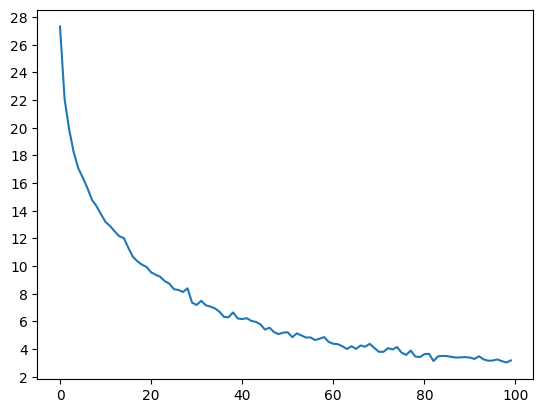

In [18]:
def rand_training_decode(*args):
    if random.random() < 0.5:
        return decode_teacher_forcing(*args)
    else:
        return decode_free_run(*args)

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=2.0)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def train_model(model:nn.Module, optimizer:optim.Optimizer, n_iters, plot_gap):
    plot_losses = []
    plot_loss_total = 0  # Reset every plot_every

    pbar = tqdm(train_dataset, total=n_iters)
    now_iter = 0
    for data in pbar:
        data, _ = data
        now_iter += 1
        loss = model(*data, decode_func=rand_training_decode)
        optimizer.step(loss)
        loss = loss.item()

        plot_loss_total += loss

        if now_iter % plot_gap == 0:
            plot_loss_avg = plot_loss_total / plot_gap
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        pbar.set_description("Loss: {:.3f}".format(loss))
        if now_iter > n_iters:
            break

    showPlot(plot_losses)
    jt.save(model.state_dict(), 'model.jt')

model = EncoderDecoder(input_lang.n_words, output_lang.n_words, hidden_size=512)
optimizer = optim.Adam(model.parameters(), lr=0.001)
skip_train = False
if not skip_train:
    train_model(model, optimizer, n_iters=10000, plot_gap=100)

### 推理阶段的解码
贪心方法：与free running类似，将预测概率最大的单词作为输出。

In [19]:
def decode_greedy(decoder, e_outputs:jt.Var, e_hiddens:jt.Var):
    """Decode Greedy

    Args:
        e_outputs (jt.Var): Encoder outputs with shape [B, max_length, hidden_size]
        e_hiddens (jt.Var): Encoder hiddens with shape [B, hidden_size]

    Returns:
        List[Int]: Generated Sentence
    """
    B, L, _ = e_outputs.shape
    assert B == 1
    decoder_hidden = e_hiddens.unsqueeze(0)                 # [1, B, hidden_size]
    decoder_input = jt.array([[SOS_token]], dtype=jt.int32)
    decoder_input = jt.repeat(decoder_input, (1, B))        # [1, B]
    generated_indices = []
    # TODO(3): simple greedy decode for inference
    # The process is basically the same as free running, 
    # except that generated_indices is of type List[int] and its length is equal t the length of the generated sequence
    # (i.e., it ends with EOS or the length has reached MAX_LENGTH)

    # Your code starts here
    for i in range(MAX_LENGTH):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, e_outputs)
        topv, topi = decoder_output.topk(1)
        generated_word_idx = topi.item() if topi.numel() == 1 else topi.squeeze().item()
        generated_indices.append(generated_word_idx)
        
        if generated_word_idx == EOS_token:
            break
        
        decoder_input = topi.transpose(0, 1)  
    # Your code ends here

    return generated_indices

In [20]:
def post_process_pred(sequence):
    results = [output_lang.index2word[r] for r in sequence]
    sentence = " ".join(results)
    return sentence

def post_process_target(target_var:jt.Var):
    assert target_var.ndim == 1 or (target_var.shape[0] == 1 and target_var.ndim == 2)
    if target_var.shape[0] == 1 and target_var.ndim == 2:
        target_var = target_var.squeeze(0)
    sequence = target_var.numpy().tolist()
    while len(sequence) > 0 and sequence[-1] == 0:
        sequence.pop()
    return post_process_pred(sequence)

def process_single(model:nn.Module, decode_func, sentence):
    data = test_dataset.process_sentence(sentence)
    sequence = model(*data, decode_func=decode_func)
    return post_process_pred(sequence)

model.eval()
model.load_state_dict(jt.load('model.jt'))
# source_sentence = 'Bonjour le monde'
source_sentence = 'Tu es un enfant délicieux'
print(process_single(model, decode_func=decode_greedy, sentence=source_sentence))


you re a kid child . <EOS>


In [21]:
def acc_eval(decode_func, n_show):
    cnt_acc, cnt_tot = 0, 0
    for eval_id, data in tqdm(enumerate(test_dataset), total=len(test_dataset)):
        data, str_pairs = data
        o_str, t_str = str_pairs
        sequence = model(*data[::2], decode_func=decode_func)
        pred = post_process_pred(sequence)
        target = post_process_target(data[1])
        if eval_id < n_show:
            print('>', o_str)
            print('=', target)
            print('<', pred)
            print('')
        cnt_tot += 1
        if pred == target:
            cnt_acc += 1
    print("acc: {:.3f} %".format(cnt_acc / cnt_tot * 100))

acc_eval(decode_func=decode_greedy, n_show=3)

  0%|          | 11/9517 [00:00<01:30, 104.83it/s]

> ['grandis un peu .']
= grow up a little . <EOS>
< a little bit . <EOS>

> ['tom ravala sa fierte .']
= tom swallowed his pride . <EOS>
< tom unfolded his pride . <EOS>

> ['qu est ce qui m est tombe dessus ?']
= what fell on me ? <EOS>
< what s on board ? <EOS>



100%|██████████| 9517/9517 [01:39<00:00, 95.42it/s] 

acc: 25.376 %
